<a href="https://colab.research.google.com/github/Nihadkaipalli/Predictive-Modeling-for-Asteroid-and-Interstellar-Object-Collision-Risk-Using-Machine-Learning/blob/main/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Necessary Libraries

In [39]:
# Install required libraries if not already installed
!pip install imbalanced-learn xgboost scikeras[tensorflow] tensorflow keras-tuner

# Import libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.experimental import enable_halving_search_cv
import keras_tuner as kt

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Save models
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 2.Load and Inspect the Dataset

In [2]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/drive/My Drive/Asteroid Collision Dataset V2.csv'
df = pd.read_csv(file_path, low_memory=False)

# Inspect the dataset
print("Dataset Shape:", df.shape)
print("First 5 Rows:\n", df.head())


Mounted at /content/drive
Dataset Shape: (677494, 79)
First 5 Rows:
    diameter  extent  albedo  rot_per  GM  BV  UB  IR spec_B  spec_T  ...  \
0       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
1       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
2       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
3       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
4       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   

        rms  two_body  A1  A1_sigma  A2  A2_sigma  A3  A3_sigma  DT  DT_sigma  
0  0.000533       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
1  0.071263       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
2  0.000002       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
3       NaN         T NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
4  0.339380       NaN NaN       NaN NaN       NaN NaN       NaN NaN       

# 3.Initial EDA

In [ ]:
print("\n--- Initial EDA (Before Preprocessing) ---")
# Basic Info
print("\nDataframe Info:")
df.info()

# Statistical Summary
print("\nStatistical Summary of Numeric Columns:")
print(df.describe(include=[np.number]))

# Check missing values again visually
missing_summary = df.isnull().mean().sort_values(ascending=False)*100
print("\nMissing Data Summary (Percentage of Missing Values):\n", missing_summary)

# Plot Missing Values
plt.figure(figsize=(10,5))
missing_summary.plot(kind='bar', color='orange')
plt.title('Percentage of Missing Values per Column (Initial)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of MOID (Before Preprocessing)
if 'moid' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['moid'], kde=True)
    plt.title('Distribution of MOID (Before Preprocessing)')
    plt.tight_layout()
    plt.show()

In [ ]:
# Correlation Heatmap (Initial)
numeric_cols_initial = df.select_dtypes(include=[np.number]).columns
corr_initial = df[numeric_cols_initial].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_initial, annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Before Preprocessing)')
plt.tight_layout()
plt.show()

# 4.Data Preprocessing

## 4.1. Handle Missing Data

In [3]:
# Analyze missing data
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
print(missing_summary)

# Drop columns with >90% missing values or irrelevant
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))

cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:")
print(cols_to_drop)


Missing Data Summary (Percentage of Missing Values):
DT_sigma          100.000000
extent            100.000000
G                 100.000000
M1                100.000000
GM                100.000000
BV                100.000000
UB                100.000000
IR                100.000000
M2                100.000000
spec_T            100.000000
DT                100.000000
K1                100.000000
K2                100.000000
PC                100.000000
name               99.999852
prefix             99.999410
A3                 99.998967
A3_sigma           99.998967
A1_sigma           99.997491
A1                 99.997491
spec_B             99.992620
A2_sigma           99.976531
A2                 99.976531
n_del_obs_used     99.910700
n_dop_obs_used     99.910700
rot_per            99.801179
two_body           99.062427
albedo             99.040582
diameter_sigma     98.987002
diameter           98.986559
H_sigma            15.064635
sigma_per           0.937868
sigma_ad          

## 4.2. Convert Columns to Numeric and Impute Missing Values

In [7]:
# Convert columns to numeric where possible
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_to_convert = list(set(df.columns) - set(numeric_columns))

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

## 4.3. Map Binary Columns

In [8]:
# Map 'Y'/'N' to 1/0 in binary columns
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)

## 4.4. Handle Date Columns

In [ ]:
# Convert date columns to datetime and extract year, month, day
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)

## 4.5. One-Hot Encode Categorical Columns

In [ ]:
# Identify remaining categorical columns
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Date conversion:", remaining_categorical_cols)

# One-hot encode the 'class' column if it exists
if 'class' in df.columns:
    df = pd.get_dummies(df, columns=['class'], prefix='class', drop_first=True)

In [ ]:
# Check unique values in the 'class' column
if 'class' in df.columns:
    print("Unique values in 'class' column:", df['class'].unique())

# 5.Feature Engineering

## 5.1. Add Derived Features

In [15]:
GRAVITATIONAL_CONSTANT = 39.478  # AU^3 / yr^2

# Add derived features
df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 5.2. Add Perturbed Features

In [ ]:
# Perturb orbital elements based on their uncertainties
for col in ['a', 'e', 'q', 'i']:
    sigma_col = f'sigma_{col}'
    if sigma_col in df.columns:
        df[f'{col}_perturbed'] = df[col] + np.random.normal(0, df[sigma_col])

## 5.3. Create Target Variable

In [ ]:
# Create 'collision_risk' based on 'moid' (Minimum Orbit Intersection Distance)
df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)

# Drop 'moid' and 'moid_ld' from features
features_to_drop = ['moid', 'moid_ld']
df.drop(columns=features_to_drop, inplace=True, errors='ignore')

# 6.Prepare Data for Modeling

## 6.1. Define Features and Target

In [19]:
# Define features and target variable
X = df.drop(columns=['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features are used
X = X.select_dtypes(include=[np.number])

## 6.2. Split the Dataset

In [20]:
# Split the dataset with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Columns with all missing values: Index(['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year',
       'tp_cal_month', 'tp_cal_day'],
      dtype='object')


## 6.3. Handle Missing Values in Training and Testing Sets

In [21]:
# Identify columns with all missing values and drop them
all_missing_cols = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", all_missing_cols.tolist())

X_train.drop(columns=all_missing_cols, inplace=True)
X_test.drop(columns=all_missing_cols, inplace=True)

# Re-impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Missing Values in X_train: 0
Missing Values in X_test: 0


## 6.4. Handle Class Imbalance with SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Set Shape:", X_train_resampled.shape)
print("Class Distribution After Resampling:\n", y_train_resampled.value_counts())

Resampled Training Set Shape: (1054508, 50) (1054508,)


In [26]:
print("Missing Values in the Entire Dataset:\n", df.isnull().sum())

Missing Values in the Entire Dataset:
 a                 0
e                 0
i                 0
om                0
w                 0
                 ..
a_perturbed       0
e_perturbed       0
q_perturbed       0
i_perturbed       0
collision_risk    0
Length: 68, dtype: int64


## 6.5. Data Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# 7.Secondary EDA

In [ ]:
print("\n--- Secondary EDA (After Preprocessing) ---")

# Check the shape and distribution again
print("Post-Preprocessing X_train_resampled_scaled shape:", X_train_resampled_scaled.shape)
print("Class Distribution in y_train_resampled:\n", y_train_resampled.value_counts())

# Plot class distribution after SMOTE
plt.figure(figsize=(5,4))
y_train_resampled.value_counts().plot(kind='bar', color='green')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Collision Risk Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap after preprocessing (use the X_train after imputation/dropping)
X_train_post = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
corr_post = pd.DataFrame(X_train_post, columns=X_train.columns).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_post, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (After Preprocessing & Resampling)')
plt.tight_layout()
plt.show()

# Distribution of a few key features after preprocessing
key_features = X_train.columns[:5]  # first 5 numeric features for demonstration
X_train_post_df = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
for feat in key_features:
    plt.figure(figsize=(6,4))
    sns.histplot(X_train_post_df[feat], kde=True)
    plt.title(f'Distribution of {feat} After Preprocessing')
    plt.tight_layout()
    plt.show()

# 8.Model Training and Evaluation

## 8.1 Random Forest Classifier

### 8.1.1. Initial Model Training

In [29]:
# Initialize the Random Forest model
rf_model_initial = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train the initial model
rf_model_initial.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_rf_initial = rf_model_initial.predict(X_test_scaled)

# Evaluate the initial model
print("Initial Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_initial, digits=4))

# Feature importance analysis
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Initial Random Forest):")
print(feature_importance_rf.head(10))

Random Forest training completed.


### 8.1.2. Hyperparameter Tuning with HalvingRandomSearchCV

In [ ]:
# Simplified parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Initialize the Random Forest model
rf_model_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize HalvingRandomSearchCV
halving_random_search_rf = HalvingRandomSearchCV(
    estimator=rf_model_base,
    param_distributions=param_grid_rf,
    factor=2,
    resource='n_estimators',
    max_resources=200,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model
halving_random_search_rf.fit(X_train_resampled_scaled, y_train_resampled)

# Best parameters
print("Best parameters found for Random Forest:")
print(halving_random_search_rf.best_params_)


### 8.1.3. Evaluate the Tuned Random Forest Model

In [30]:
# Use the best estimator
best_rf_model = halving_random_search_rf.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

print("Tuned Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Tuned Random Forest Accuracy:", accuracy_rf)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9955    0.9975    131814
           1     0.8586    0.9872    0.9185      3685

    accuracy                         0.9952    135499
   macro avg     0.9291    0.9914    0.9580    135499
weighted avg     0.9958    0.9952    0.9954    135499

Random Forest Confusion Matrix:
[[131215    599]
 [    47   3638]]
Random Forest Accuracy: 0.9952324371397575


## 8.2 Gradient Boosting Classifier (XGBoost)

### 8.2.1. Initial Model Training

In [35]:
# Initialize the XGBoost model
xgb_model_initial = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the initial model
xgb_model_initial.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_xgb_initial = xgb_model_initial.predict(X_test_scaled)

# Evaluate the initial model
print("Initial XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_initial, digits=4))

# Feature importance analysis
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Initial XGBoost):")
print(feature_importance_xgb.head(10))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:36:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training completed.


### 8.2.2 Hyperparameter Tuning with RandomizedSearchCV and Early Stopping

In [36]:
# Simplified parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1]  # Since classes are balanced after SMOTE
}

# Initialize the XGBoost model
xgb_model_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_base,
    param_distributions=param_grid_xgb,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model with early stopping
random_search_xgb.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

# Best parameters
print("Best parameters found for XGBoost:")
print(random_search_xgb.best_params_)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9972    0.9982    131814
           1     0.9057    0.9723    0.9378      3685

    accuracy                         0.9965    135499
   macro avg     0.9525    0.9847    0.9680    135499
weighted avg     0.9967    0.9965    0.9966    135499

XGBoost Confusion Matrix:
[[131441    373]
 [   102   3583]]
XGBoost Accuracy: 0.9964944390733511


### 8.2.3 Evaluate the Tuned XGBoost Model

Top 10 Most Important Features (XGBoost):
                      Feature  Importance
5                           q    0.904331
48                q_perturbed    0.030827
14                        pha    0.022257
13                        neo    0.006508
11                          H    0.004867
43  relative_orbital_distance    0.003315
9              condition_code    0.002372
7                       per_y    0.001929
41             last_obs_month    0.001708
49                i_perturbed    0.001238


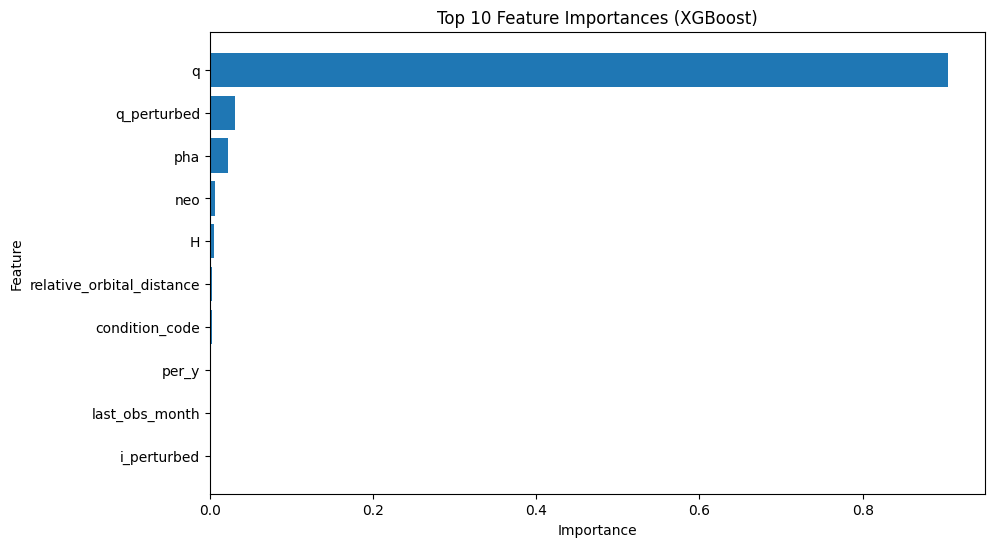

In [37]:
# Use the best estimator
best_xgb_model = random_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("Tuned XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Tuned XGBoost Accuracy:", accuracy_xgb)

## 8.3 Neural Network with Keras Tuner and Hyperband

### 8.3.1. Define the Model-Building Function

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', input_shape=(X_train_resampled_scaled.shape[1],)))
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(rate=hp_dropout))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile the model
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    model.compile(optimizer=hp_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 8.3.2. Initialize the Hyperband Tuner

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband_dir',
    project_name='collision_risk_tuning'
)

### 8.3.3. Run the Hyperparameter Search

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(
    X_train_resampled_scaled,
    y_train_resampled,
    epochs=10,
    validation_data=(X_test_scaled, y_test),
    callbacks=[stop_early],
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found for Neural Network:")
print(f"Units: {best_hps.get('units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

### 8.3.4. Build and Train the Best Model

In [ ]:
# Build the best model
nn_model = tuner.hypermodel.build(best_hps)

# Train the model
history = nn_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    epochs=10,
    validation_data=(X_test_scaled, y_test),
    callbacks=[stop_early],
    verbose=1
)

### 8.3.5. Evaluate the Tuned Neural Network Model

In [ ]:
# Make predictions on the test set
y_pred_nn_prob = nn_model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_nn_prob >= 0.5).astype(int)

# Evaluate the model
print("Tuned Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn, digits=4))

print("Tuned Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

# Accuracy score
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("Tuned Neural Network Accuracy:", accuracy_nn)

# 9. Model Evaluation and Comparison

## 9.1. Extract Metrics for Minority Class

In [ ]:
# Function to extract metrics for the minority class
def get_minority_class_metrics(report):
    lines = report.strip().split('\n')
    for line in lines[2:]:
        if line.strip().startswith('1 '):
            values = line.strip().split()
            precision = float(values[1])
            recall = float(values[2])
            f1_score = float(values[3])
            support = int(values[4])
            return precision, recall, f1_score, support

## 9.2. Compile Metrics for Comparison

In [ ]:
# Extract metrics for the tuned models
models = ['Random Forest', 'XGBoost', 'Neural Network']
reports = [classification_report(y_test, y_pred_rf, digits=4),
           classification_report(y_test, y_pred_xgb, digits=4),
           classification_report(y_test, y_pred_nn, digits=4)]

metrics = []
for model_name, report in zip(models, reports):
    precision, recall, f1_score, support = get_minority_class_metrics(report)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })

# Create DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the comparison
print("\nComparison of Tuned Models on Minority Class Metrics:")
print(metrics_df)

## 9.3. Visualize Metrics

In [ ]:
# Plotting the metrics for comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Precision
ax[0].bar(metrics_df['Model'], metrics_df['Precision'], color='blue')
ax[0].set_title('Precision for Minority Class')
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('Precision')

# Recall
ax[1].bar(metrics_df['Model'], metrics_df['Recall'], color='green')
ax[1].set_title('Recall for Minority Class')
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Recall')

# F1-Score
ax[2].bar(metrics_df['Model'], metrics_df['F1-Score'], color='red')
ax[2].set_title('F1-Score for Minority Class')
ax[2].set_ylim([0, 1])
ax[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()

# 10. Save the Best Models

In [ ]:
# Save the best Random Forest model
joblib.dump(best_rf_model, 'best_random_forest_model.pkl')

# Save the best XGBoost model
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')

# Save the best Neural Network model
nn_model.save('best_neural_network_model.h5')